In [1]:
import os

os.environ["USE_PYGEOS"] = "0"

import fiona
import geopandas as gpd
import pandas as pd
import requests
from odc.geo import XY, BoundingBox
from odc.geo.gridspec import GridSpec

In [2]:
# Create a gridspec for Vietnam
vietnam_epsg = "EPSG:3405"
vietnam_gridspec = GridSpec(crs=vietnam_epsg, tile_shape=(2000,2000), resolution=25, origin=XY(0, 0))

In [3]:
# Select relevant tiles and convert to Geopandas
bounds = BoundingBox(100, 0, 125, 25, crs="EPSG:4326").to_crs(vietnam_epsg)
geom = vietnam_gridspec.geojson(bbox=bounds)
tiles_projected = gpd.GeoDataFrame.from_features(geom, crs="EPSG:4326").to_crs(vietnam_epsg)

In [4]:
# Get the Natural Earth country boundaries dataset
ne_url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
natural_earth_10m = gpd.read_file(ne_url)

In [6]:
# Prepare a dataset that contains continental coastlines with a 15 km buffer
vietnam = natural_earth_10m[natural_earth_10m["ADMIN"] == "Vietnam"].to_crs(vietnam_epsg)
asia = natural_earth_10m[natural_earth_10m["CONTINENT"] == "Asia"]
asia_coast = asia.dissolve().boundary.to_crs(vietnam_epsg)
asia_coast_buffer = asia_coast.buffer(15_000)

# Pick out coasts that are within 50 km of Vietnam
vietnam_coasts = vietnam.buffer(50_000).clip(asia_coast_buffer.set_crs(vietnam_epsg))

/var/folders/p8/zk3xfwk969vdx8d5284hrgww0000gn/T/ipykernel_63149/106146329.py:11: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  vietnam_exploded = vietnam_admin.explode().to_crs(vietnam_epsg)


In [ ]:
# Use OpenStreetMap data for small islands excluded from NE coastlines
# Download the OSM global land polygons from https://osmdata.openstreetmap.de/data/land-polygons.html
# Manually edit the downloaded file "land_polygons.shp" to include only features of interest
# Save the coastline of interest as geojson file at "data/raw/osm_islands.geojson"
# Open the coastline geojson file using fiona
osm_islands_polygon = gpd.read_file("../data/raw/osm_islands.geojson")
osm_islands_polygon.set_crs("EPSG:4326")
osm_islands_polygon = osm_islands_polygon.to_crs(vietnam_epsg)

# Buffer polygons to 15 km
osm_islands_buffer = osm_islands_polygon.buffer(15_000)

In [ ]:
# Include remaining very small islands with data from https://amti.csis.org/scs-features-map/
# Filter the downloaded file "All_SCS_Features.gpkg" using Rock = 'Y' and manually edit the file to include only features of interest
# Save the points as geojson file at "data/raw/amti_islands.geojson
# Read data
amti_islands_point = gpd.read_file("../data/raw/amti_islands.geojson")
amti_islands_point.set_crs("EPSG:4326")
amti_islands_point = amti_islands_point.to_crs(vietnam_epsg)

# Buffer points to 15 km
amti_islands_buffer = amti_islands_point.buffer(15_000)

In [7]:
# Define AOI as union of continental and island datasets
aoi = gpd.GeoDataFrame(pd.concat([osm_islands_buffer, amti_islands_buffer, vietnam_coasts], ignore_index=True), geometry=0).unary_union

<Axes: >

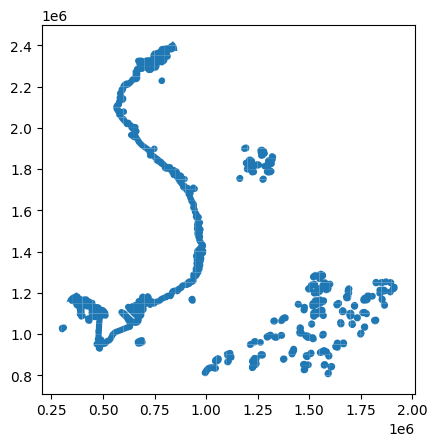

In [8]:
# Clip tiles to AOI
vietnam_coastal_tiles_clipped = tiles_projected.clip(aoi)
vietnam_coastal_tiles_clipped.plot()

In [9]:
# Export the results as GeoJSON
vietnam_coastal_tiles_clipped.rename(columns={'idx': 'id'}, inplace=True)
vietnam_coastal_tiles_clipped.to_crs("EPSG:4326").to_file("../data/raw/vietnam_tiles.geojson", driver='GeoJSON')